# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.44KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

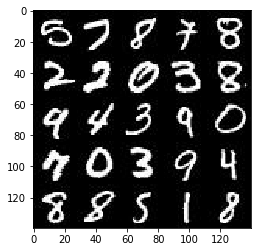

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

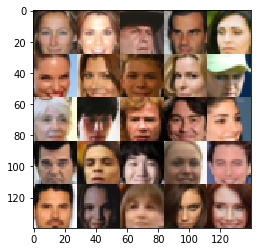

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="real_input")
    z_input=tf.placeholder(tf.float32,(None,z_dim),name="z_input")
    learning_rate=tf.placeholder(tf.float32,(None),name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        hidden_layer1 = tf.layers.conv2d(images, 32, 5, 2, 'same')
        relu_layer1= tf.maximum(alpha *hidden_layer1, hidden_layer1)
        
        hidden_layer2 = tf.layers.conv2d(relu_layer1, 64, 5, 2, 'same')
        batch_layer2 = tf.layers.batch_normalization(hidden_layer2, training=True)
        relu_layer2 = tf.maximum(alpha * batch_layer2, batch_layer2)
        
        hidden_layer3 = tf.layers.conv2d(relu_layer2, 512, 5, 2, 'same')
        batch_layer3 = tf.layers.batch_normalization(hidden_layer3, training=True)
        relu_layer3 = tf.maximum(alpha * batch_layer3, batch_layer3)
        
        flat = tf.reshape(relu_layer3, (-1, 4*4*1024))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        hidden_layer1 = tf.layers.dense(z, 2*2*512)
        hidden_layer1 = tf.reshape(hidden_layer1, (-1, 2, 2, 512))
        batch_layer1 = tf.layers.batch_normalization(hidden_layer1, training=is_train)
        relu_layer1 = tf.maximum(alpha * batch_layer1, batch_layer1)
    
        hidden_layer2 = tf.layers.conv2d_transpose(relu_layer1, 256, 5, 2, 'valid')
        batch_layer2 = tf.layers.batch_normalization(hidden_layer2, training=is_train)
        relu_layer2 = tf.maximum(alpha * batch_layer2, batch_layer2)
    
        hidden_layer3 = tf.layers.conv2d_transpose(relu_layer2, 128, 5, 2, 'same')
        batch_layer3 = tf.layers.batch_normalization(hidden_layer3, training=is_train)
        relu_layer3 = tf.maximum(alpha * batch_layer3, batch_layer3)
    
        logits = tf.layers.conv2d_transpose(relu_layer3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
 
        return out 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim)
    discriminator_real_model, discriminator_real_logits = discriminator(input_real)
    discriminator_fake_model, discriminator_fake_logits = discriminator(generator_model, reuse=True)
    
    #discriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real_model)*(1-smooth)))
    #d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_real_logits, labels=tf.ones_like(discriminator_real_model)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.zeros_like(discriminator_real_model)))
    d_loss = d_loss_real + d_loss_fake
    
    #generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_fake_logits, labels=tf.ones_like(discriminator_fake_model)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_variables = tf.trainable_variables()
    discriminator_variables = [var for var in training_variables if 'discriminator' in var.name]
    generator_variables = [var for var in training_variables if 'generator' in  var.name]
     
    training_discriminator_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
   
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    generator_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(generator_updates):
        training_generator_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=generator_variables)
        
    return training_discriminator_opt, training_generator_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    real_input, z_input, rate_learn = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    discriminator_opt, generator_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    i = 0
    losses = []
      
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i += 1
                batch_images *= 2.0
                
                #input random noise
                input_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                #optimitizers
                _ = sess.run(discriminator_opt, feed_dict={real_input: batch_images, z_input: input_z, rate_learn: learning_rate})
                _ = sess.run(generator_opt, feed_dict={z_input: input_z, rate_learn: learning_rate})
                
                if i % 20 == 0:
                    d_training_loss = d_loss.eval({z_input: input_z, real_input: batch_images})
                    g_training_loss = g_loss.eval({z_input: input_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),"Discriminator_Loss: {:.5f}...".format(d_training_loss),"Generator_Loss: {:.5f}".format(g_training_loss))
                    losses.append((d_training_loss, g_training_loss))
                    
                #output Every 100 batches
                if i % 100 == 0:
                    show_generator_output(sess, 25, z_input, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator_Loss: 6.01582... Generator_Loss: 0.00416
Epoch 1/2... Discriminator_Loss: 2.10273... Generator_Loss: 0.22873
Epoch 1/2... Discriminator_Loss: 1.36140... Generator_Loss: 0.51647
Epoch 1/2... Discriminator_Loss: 0.75511... Generator_Loss: 2.50930
Epoch 1/2... Discriminator_Loss: 2.02047... Generator_Loss: 0.26968


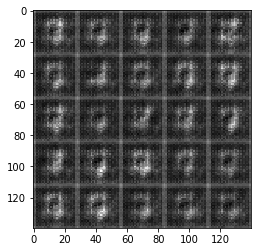

Epoch 1/2... Discriminator_Loss: 1.47676... Generator_Loss: 1.91695
Epoch 1/2... Discriminator_Loss: 0.85199... Generator_Loss: 1.34544
Epoch 1/2... Discriminator_Loss: 1.42222... Generator_Loss: 0.53982
Epoch 1/2... Discriminator_Loss: 0.92616... Generator_Loss: 1.86063
Epoch 1/2... Discriminator_Loss: 1.75612... Generator_Loss: 0.31291


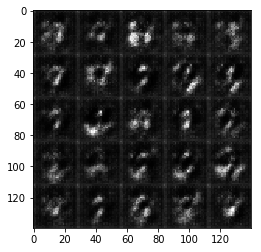

Epoch 1/2... Discriminator_Loss: 1.74229... Generator_Loss: 0.37794
Epoch 1/2... Discriminator_Loss: 1.43607... Generator_Loss: 1.30221
Epoch 1/2... Discriminator_Loss: 1.99109... Generator_Loss: 2.27727
Epoch 1/2... Discriminator_Loss: 1.09093... Generator_Loss: 1.97661
Epoch 1/2... Discriminator_Loss: 1.63332... Generator_Loss: 0.34890


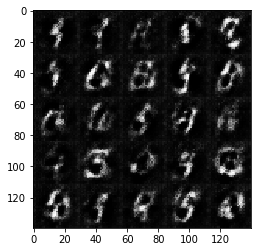

Epoch 1/2... Discriminator_Loss: 1.49729... Generator_Loss: 0.43529
Epoch 1/2... Discriminator_Loss: 1.22716... Generator_Loss: 0.88520
Epoch 1/2... Discriminator_Loss: 2.06882... Generator_Loss: 0.22177
Epoch 1/2... Discriminator_Loss: 1.24774... Generator_Loss: 0.68681
Epoch 1/2... Discriminator_Loss: 1.40584... Generator_Loss: 0.54004


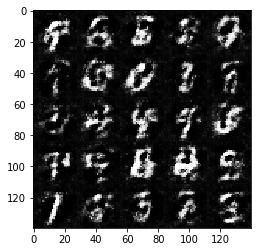

Epoch 1/2... Discriminator_Loss: 1.09760... Generator_Loss: 1.58187
Epoch 1/2... Discriminator_Loss: 0.98092... Generator_Loss: 1.52886
Epoch 1/2... Discriminator_Loss: 1.05672... Generator_Loss: 1.28313
Epoch 1/2... Discriminator_Loss: 1.73447... Generator_Loss: 0.31949
Epoch 1/2... Discriminator_Loss: 0.93816... Generator_Loss: 1.54235


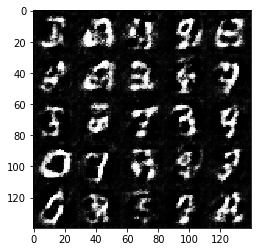

Epoch 1/2... Discriminator_Loss: 1.17565... Generator_Loss: 0.67759
Epoch 1/2... Discriminator_Loss: 1.53960... Generator_Loss: 0.43104
Epoch 1/2... Discriminator_Loss: 1.55961... Generator_Loss: 0.41084
Epoch 1/2... Discriminator_Loss: 1.52119... Generator_Loss: 0.47145
Epoch 1/2... Discriminator_Loss: 0.98553... Generator_Loss: 1.07675


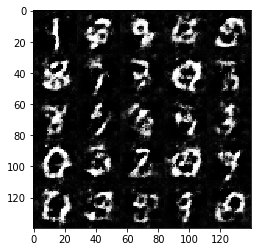

Epoch 1/2... Discriminator_Loss: 1.17312... Generator_Loss: 1.47724
Epoch 1/2... Discriminator_Loss: 0.97137... Generator_Loss: 1.25182
Epoch 1/2... Discriminator_Loss: 1.04000... Generator_Loss: 1.02225
Epoch 1/2... Discriminator_Loss: 1.04794... Generator_Loss: 1.28661
Epoch 1/2... Discriminator_Loss: 1.86919... Generator_Loss: 0.26774


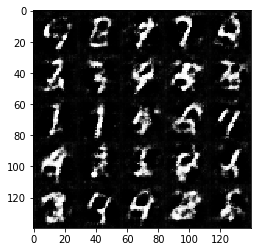

Epoch 1/2... Discriminator_Loss: 1.37631... Generator_Loss: 0.49764
Epoch 1/2... Discriminator_Loss: 1.05021... Generator_Loss: 0.95918
Epoch 1/2... Discriminator_Loss: 1.63760... Generator_Loss: 0.43991
Epoch 1/2... Discriminator_Loss: 1.81670... Generator_Loss: 0.32547
Epoch 1/2... Discriminator_Loss: 0.84893... Generator_Loss: 1.18781


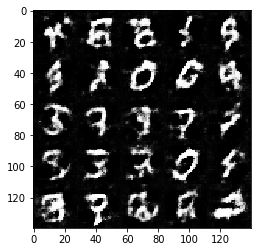

Epoch 1/2... Discriminator_Loss: 1.82314... Generator_Loss: 0.26863
Epoch 1/2... Discriminator_Loss: 1.61399... Generator_Loss: 2.37472
Epoch 1/2... Discriminator_Loss: 1.10192... Generator_Loss: 1.47880
Epoch 1/2... Discriminator_Loss: 1.03532... Generator_Loss: 1.24427
Epoch 1/2... Discriminator_Loss: 1.11434... Generator_Loss: 0.78979


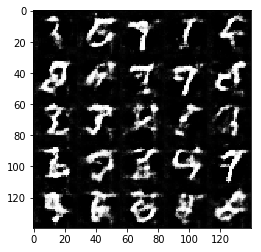

Epoch 1/2... Discriminator_Loss: 1.40307... Generator_Loss: 0.48897
Epoch 1/2... Discriminator_Loss: 1.66530... Generator_Loss: 0.40457
Epoch 1/2... Discriminator_Loss: 1.16792... Generator_Loss: 0.70523
Epoch 1/2... Discriminator_Loss: 1.13260... Generator_Loss: 0.83562
Epoch 1/2... Discriminator_Loss: 1.57707... Generator_Loss: 0.37569


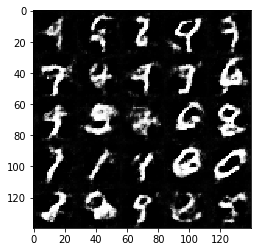

Epoch 1/2... Discriminator_Loss: 1.28798... Generator_Loss: 0.52374
Epoch 1/2... Discriminator_Loss: 1.24091... Generator_Loss: 0.82735
Epoch 1/2... Discriminator_Loss: 1.13327... Generator_Loss: 1.11971
Epoch 1/2... Discriminator_Loss: 1.51092... Generator_Loss: 0.48713
Epoch 1/2... Discriminator_Loss: 1.43003... Generator_Loss: 0.46628


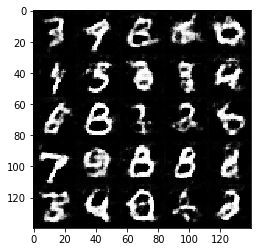

Epoch 1/2... Discriminator_Loss: 1.51782... Generator_Loss: 0.43086
Epoch 1/2... Discriminator_Loss: 1.22657... Generator_Loss: 0.60124
Epoch 1/2... Discriminator_Loss: 1.32818... Generator_Loss: 0.57946
Epoch 1/2... Discriminator_Loss: 1.19119... Generator_Loss: 1.58734
Epoch 1/2... Discriminator_Loss: 1.29989... Generator_Loss: 0.60005


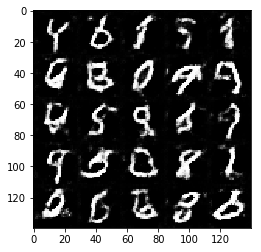

Epoch 1/2... Discriminator_Loss: 1.06437... Generator_Loss: 1.92703
Epoch 1/2... Discriminator_Loss: 1.90105... Generator_Loss: 0.31059
Epoch 1/2... Discriminator_Loss: 1.19129... Generator_Loss: 1.27869
Epoch 1/2... Discriminator_Loss: 1.00102... Generator_Loss: 1.05366
Epoch 1/2... Discriminator_Loss: 1.17737... Generator_Loss: 0.61835


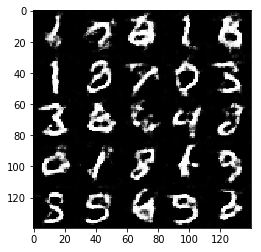

Epoch 1/2... Discriminator_Loss: 1.58958... Generator_Loss: 0.39792
Epoch 1/2... Discriminator_Loss: 1.27772... Generator_Loss: 0.54415
Epoch 1/2... Discriminator_Loss: 1.19422... Generator_Loss: 0.71546
Epoch 1/2... Discriminator_Loss: 1.74879... Generator_Loss: 0.31186
Epoch 1/2... Discriminator_Loss: 1.04059... Generator_Loss: 0.79882


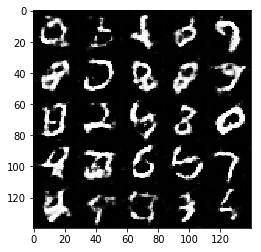

Epoch 1/2... Discriminator_Loss: 0.94791... Generator_Loss: 1.27223
Epoch 1/2... Discriminator_Loss: 1.01659... Generator_Loss: 1.09966
Epoch 1/2... Discriminator_Loss: 1.04452... Generator_Loss: 1.15947
Epoch 1/2... Discriminator_Loss: 0.94740... Generator_Loss: 1.09619
Epoch 1/2... Discriminator_Loss: 1.23432... Generator_Loss: 1.77655


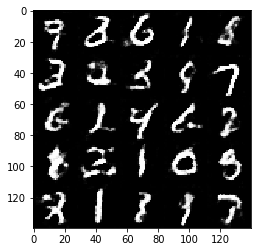

Epoch 1/2... Discriminator_Loss: 0.99983... Generator_Loss: 1.15795
Epoch 1/2... Discriminator_Loss: 1.12380... Generator_Loss: 1.81512
Epoch 1/2... Discriminator_Loss: 1.13207... Generator_Loss: 0.73545
Epoch 1/2... Discriminator_Loss: 1.18681... Generator_Loss: 0.64021
Epoch 1/2... Discriminator_Loss: 1.63235... Generator_Loss: 0.36891


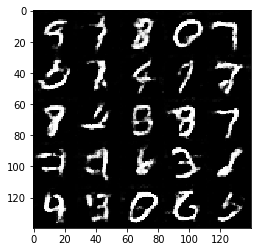

Epoch 1/2... Discriminator_Loss: 1.94335... Generator_Loss: 0.29975
Epoch 1/2... Discriminator_Loss: 1.54973... Generator_Loss: 2.79626
Epoch 1/2... Discriminator_Loss: 1.32372... Generator_Loss: 0.59645
Epoch 1/2... Discriminator_Loss: 0.81662... Generator_Loss: 1.52515
Epoch 1/2... Discriminator_Loss: 0.85185... Generator_Loss: 1.26632


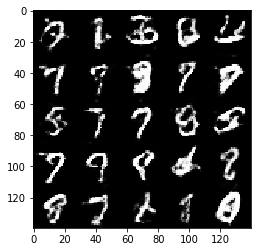

Epoch 1/2... Discriminator_Loss: 1.39474... Generator_Loss: 2.76431
Epoch 1/2... Discriminator_Loss: 1.70927... Generator_Loss: 3.18570
Epoch 1/2... Discriminator_Loss: 1.00540... Generator_Loss: 0.90259
Epoch 1/2... Discriminator_Loss: 1.20144... Generator_Loss: 0.68378
Epoch 1/2... Discriminator_Loss: 1.70664... Generator_Loss: 0.38087


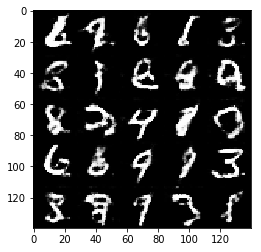

Epoch 1/2... Discriminator_Loss: 1.11827... Generator_Loss: 1.66157
Epoch 1/2... Discriminator_Loss: 0.90944... Generator_Loss: 0.98449
Epoch 1/2... Discriminator_Loss: 1.96003... Generator_Loss: 0.28478
Epoch 2/2... Discriminator_Loss: 0.92854... Generator_Loss: 0.97964
Epoch 2/2... Discriminator_Loss: 1.53698... Generator_Loss: 0.40691


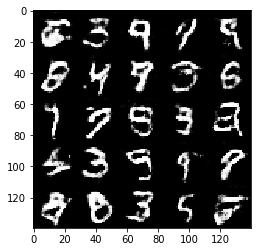

Epoch 2/2... Discriminator_Loss: 0.98933... Generator_Loss: 0.96666
Epoch 2/2... Discriminator_Loss: 1.73384... Generator_Loss: 0.35151
Epoch 2/2... Discriminator_Loss: 0.88627... Generator_Loss: 1.00136
Epoch 2/2... Discriminator_Loss: 1.33484... Generator_Loss: 0.52000
Epoch 2/2... Discriminator_Loss: 1.19608... Generator_Loss: 0.66118


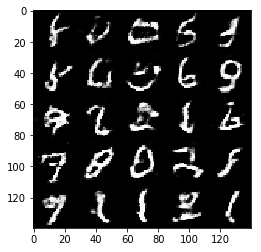

Epoch 2/2... Discriminator_Loss: 0.76217... Generator_Loss: 1.65503
Epoch 2/2... Discriminator_Loss: 2.09250... Generator_Loss: 4.23790
Epoch 2/2... Discriminator_Loss: 0.99626... Generator_Loss: 0.86714
Epoch 2/2... Discriminator_Loss: 0.99374... Generator_Loss: 0.89001
Epoch 2/2... Discriminator_Loss: 2.28059... Generator_Loss: 0.22417


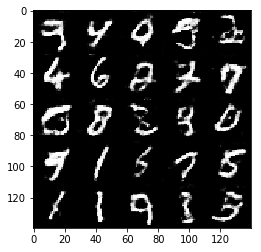

Epoch 2/2... Discriminator_Loss: 0.89139... Generator_Loss: 1.77152
Epoch 2/2... Discriminator_Loss: 1.44979... Generator_Loss: 0.46751
Epoch 2/2... Discriminator_Loss: 1.22456... Generator_Loss: 3.34626
Epoch 2/2... Discriminator_Loss: 1.10404... Generator_Loss: 0.71770
Epoch 2/2... Discriminator_Loss: 1.16705... Generator_Loss: 2.75917


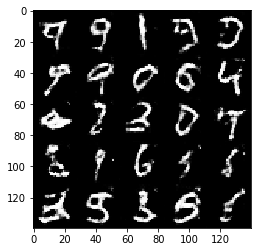

Epoch 2/2... Discriminator_Loss: 0.83272... Generator_Loss: 1.24029
Epoch 2/2... Discriminator_Loss: 1.04319... Generator_Loss: 0.79181
Epoch 2/2... Discriminator_Loss: 0.93165... Generator_Loss: 0.92733
Epoch 2/2... Discriminator_Loss: 1.56243... Generator_Loss: 0.37355
Epoch 2/2... Discriminator_Loss: 0.83241... Generator_Loss: 1.37172


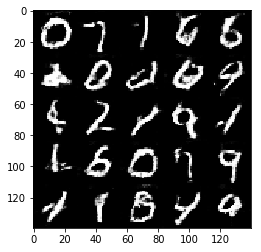

Epoch 2/2... Discriminator_Loss: 1.60407... Generator_Loss: 0.42494
Epoch 2/2... Discriminator_Loss: 0.84188... Generator_Loss: 1.08741
Epoch 2/2... Discriminator_Loss: 2.87671... Generator_Loss: 0.13837
Epoch 2/2... Discriminator_Loss: 0.88471... Generator_Loss: 1.82989
Epoch 2/2... Discriminator_Loss: 0.89882... Generator_Loss: 1.16544


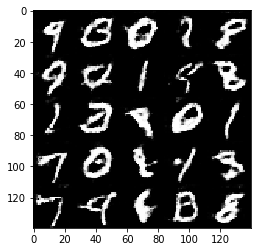

Epoch 2/2... Discriminator_Loss: 0.88107... Generator_Loss: 0.93590
Epoch 2/2... Discriminator_Loss: 0.77894... Generator_Loss: 1.31893
Epoch 2/2... Discriminator_Loss: 0.83531... Generator_Loss: 1.25292
Epoch 2/2... Discriminator_Loss: 2.99065... Generator_Loss: 0.15092
Epoch 2/2... Discriminator_Loss: 1.64594... Generator_Loss: 3.62521


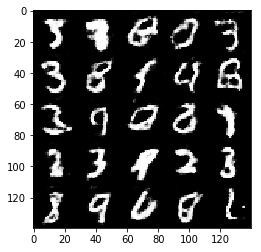

Epoch 2/2... Discriminator_Loss: 1.56905... Generator_Loss: 0.45357
Epoch 2/2... Discriminator_Loss: 0.78869... Generator_Loss: 1.13432
Epoch 2/2... Discriminator_Loss: 1.33206... Generator_Loss: 0.56084
Epoch 2/2... Discriminator_Loss: 0.94200... Generator_Loss: 1.03609
Epoch 2/2... Discriminator_Loss: 1.53171... Generator_Loss: 0.48961


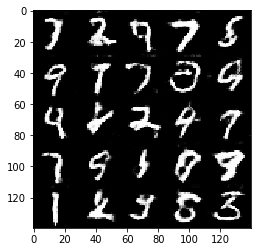

Epoch 2/2... Discriminator_Loss: 1.00601... Generator_Loss: 1.20551
Epoch 2/2... Discriminator_Loss: 0.92083... Generator_Loss: 1.01283
Epoch 2/2... Discriminator_Loss: 1.72373... Generator_Loss: 0.36206
Epoch 2/2... Discriminator_Loss: 1.50517... Generator_Loss: 0.48674
Epoch 2/2... Discriminator_Loss: 2.60547... Generator_Loss: 0.21314


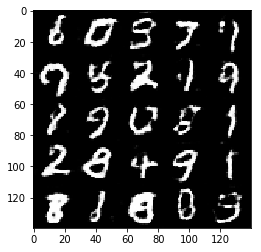

Epoch 2/2... Discriminator_Loss: 0.90605... Generator_Loss: 1.16025
Epoch 2/2... Discriminator_Loss: 0.97081... Generator_Loss: 0.88451
Epoch 2/2... Discriminator_Loss: 1.05967... Generator_Loss: 2.89501
Epoch 2/2... Discriminator_Loss: 0.69825... Generator_Loss: 1.85934
Epoch 2/2... Discriminator_Loss: 3.30421... Generator_Loss: 0.11855


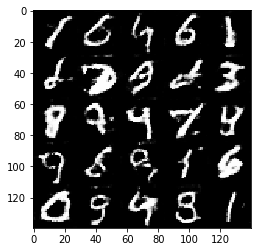

Epoch 2/2... Discriminator_Loss: 0.89893... Generator_Loss: 1.89073
Epoch 2/2... Discriminator_Loss: 1.76853... Generator_Loss: 0.39556
Epoch 2/2... Discriminator_Loss: 0.68813... Generator_Loss: 2.08300
Epoch 2/2... Discriminator_Loss: 1.08834... Generator_Loss: 0.80762
Epoch 2/2... Discriminator_Loss: 1.41253... Generator_Loss: 0.50188


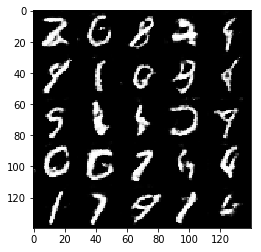

Epoch 2/2... Discriminator_Loss: 0.73259... Generator_Loss: 1.44389
Epoch 2/2... Discriminator_Loss: 0.67936... Generator_Loss: 1.53402
Epoch 2/2... Discriminator_Loss: 1.04742... Generator_Loss: 0.78393
Epoch 2/2... Discriminator_Loss: 0.85801... Generator_Loss: 2.00342
Epoch 2/2... Discriminator_Loss: 0.70296... Generator_Loss: 1.33976


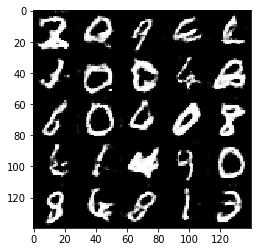

Epoch 2/2... Discriminator_Loss: 0.82113... Generator_Loss: 1.19108
Epoch 2/2... Discriminator_Loss: 0.73774... Generator_Loss: 1.33621
Epoch 2/2... Discriminator_Loss: 0.60224... Generator_Loss: 1.87119
Epoch 2/2... Discriminator_Loss: 0.72162... Generator_Loss: 1.27036
Epoch 2/2... Discriminator_Loss: 0.98704... Generator_Loss: 0.87559


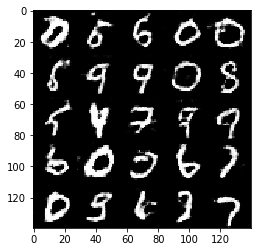

Epoch 2/2... Discriminator_Loss: 1.09626... Generator_Loss: 0.70672
Epoch 2/2... Discriminator_Loss: 0.72632... Generator_Loss: 2.11681
Epoch 2/2... Discriminator_Loss: 1.10202... Generator_Loss: 0.67131
Epoch 2/2... Discriminator_Loss: 2.06079... Generator_Loss: 0.29388
Epoch 2/2... Discriminator_Loss: 0.85895... Generator_Loss: 2.42586


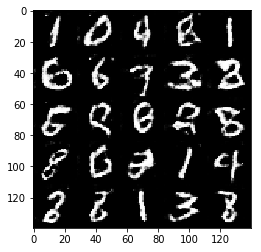

Epoch 2/2... Discriminator_Loss: 0.66151... Generator_Loss: 1.55751
Epoch 2/2... Discriminator_Loss: 1.24647... Generator_Loss: 0.60866
Epoch 2/2... Discriminator_Loss: 1.10485... Generator_Loss: 0.87470
Epoch 2/2... Discriminator_Loss: 1.07781... Generator_Loss: 0.78168
Epoch 2/2... Discriminator_Loss: 0.67779... Generator_Loss: 1.45360


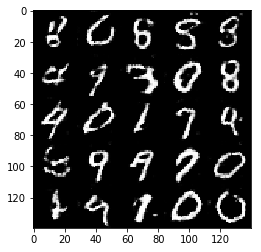

Epoch 2/2... Discriminator_Loss: 0.78921... Generator_Loss: 1.12586
Epoch 2/2... Discriminator_Loss: 0.70029... Generator_Loss: 1.39137
Epoch 2/2... Discriminator_Loss: 0.73014... Generator_Loss: 2.06101
Epoch 2/2... Discriminator_Loss: 0.97139... Generator_Loss: 0.85720
Epoch 2/2... Discriminator_Loss: 0.74990... Generator_Loss: 1.46600


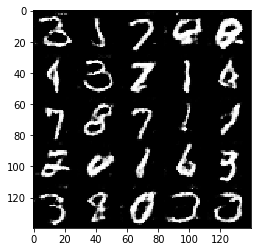

Epoch 2/2... Discriminator_Loss: 0.89415... Generator_Loss: 1.02165
Epoch 2/2... Discriminator_Loss: 1.00773... Generator_Loss: 0.88246
Epoch 2/2... Discriminator_Loss: 0.82912... Generator_Loss: 1.14647
Epoch 2/2... Discriminator_Loss: 0.96311... Generator_Loss: 0.86035
Epoch 2/2... Discriminator_Loss: 0.79178... Generator_Loss: 1.21220


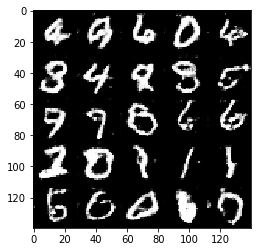

Epoch 2/2... Discriminator_Loss: 0.71848... Generator_Loss: 2.31204
Epoch 2/2... Discriminator_Loss: 1.03903... Generator_Loss: 0.87878
Epoch 2/2... Discriminator_Loss: 0.98283... Generator_Loss: 0.86423
Epoch 2/2... Discriminator_Loss: 0.65793... Generator_Loss: 2.16020
Epoch 2/2... Discriminator_Loss: 0.88635... Generator_Loss: 1.05732


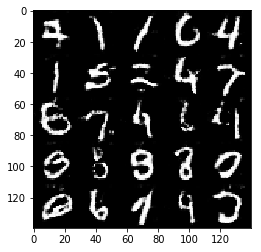

Epoch 2/2... Discriminator_Loss: 4.05055... Generator_Loss: 0.07888
Epoch 2/2... Discriminator_Loss: 0.83120... Generator_Loss: 1.12174
Epoch 2/2... Discriminator_Loss: 0.78944... Generator_Loss: 1.11628
Epoch 2/2... Discriminator_Loss: 1.03664... Generator_Loss: 0.81498
Epoch 2/2... Discriminator_Loss: 0.57467... Generator_Loss: 2.11817


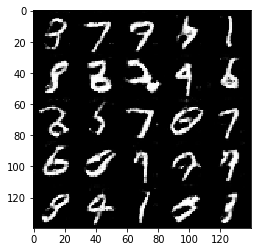

Epoch 2/2... Discriminator_Loss: 0.84993... Generator_Loss: 1.01609
Epoch 2/2... Discriminator_Loss: 1.19288... Generator_Loss: 0.76374


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator_Loss: 4.45863... Generator_Loss: 0.02153
Epoch 1/1... Discriminator_Loss: 1.58591... Generator_Loss: 9.62691
Epoch 1/1... Discriminator_Loss: 1.88807... Generator_Loss: 0.31610
Epoch 1/1... Discriminator_Loss: 0.60183... Generator_Loss: 6.97376
Epoch 1/1... Discriminator_Loss: 1.60840... Generator_Loss: 12.73172


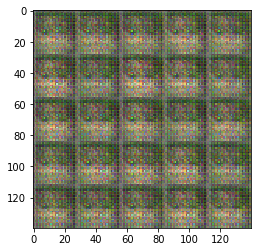

Epoch 1/1... Discriminator_Loss: 0.73782... Generator_Loss: 1.40198
Epoch 1/1... Discriminator_Loss: 1.44967... Generator_Loss: 0.59403
Epoch 1/1... Discriminator_Loss: 1.51799... Generator_Loss: 0.52053
Epoch 1/1... Discriminator_Loss: 1.56142... Generator_Loss: 1.28642
Epoch 1/1... Discriminator_Loss: 2.05170... Generator_Loss: 2.74024


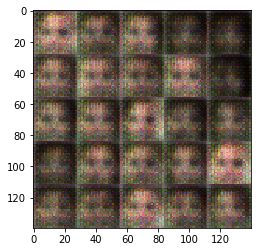

Epoch 1/1... Discriminator_Loss: 1.46158... Generator_Loss: 2.08244
Epoch 1/1... Discriminator_Loss: 1.28047... Generator_Loss: 1.28871
Epoch 1/1... Discriminator_Loss: 1.49390... Generator_Loss: 0.46941
Epoch 1/1... Discriminator_Loss: 1.30499... Generator_Loss: 0.77173
Epoch 1/1... Discriminator_Loss: 1.43347... Generator_Loss: 0.53075


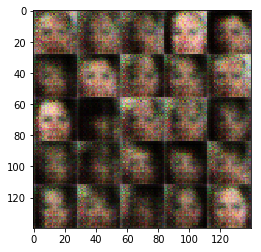

Epoch 1/1... Discriminator_Loss: 1.65583... Generator_Loss: 1.50611
Epoch 1/1... Discriminator_Loss: 1.33749... Generator_Loss: 0.82002
Epoch 1/1... Discriminator_Loss: 1.15196... Generator_Loss: 1.30975
Epoch 1/1... Discriminator_Loss: 1.31897... Generator_Loss: 1.55799
Epoch 1/1... Discriminator_Loss: 1.26390... Generator_Loss: 0.62367


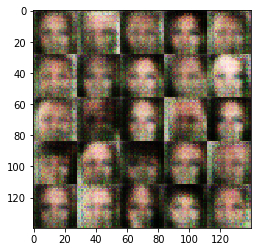

Epoch 1/1... Discriminator_Loss: 1.84771... Generator_Loss: 0.30901
Epoch 1/1... Discriminator_Loss: 1.83520... Generator_Loss: 0.40288
Epoch 1/1... Discriminator_Loss: 1.27693... Generator_Loss: 0.67569
Epoch 1/1... Discriminator_Loss: 1.30605... Generator_Loss: 1.13211
Epoch 1/1... Discriminator_Loss: 1.58533... Generator_Loss: 2.30976


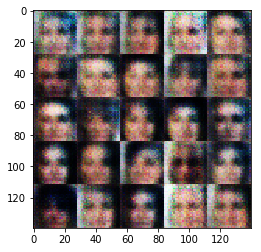

Epoch 1/1... Discriminator_Loss: 1.06932... Generator_Loss: 1.56005
Epoch 1/1... Discriminator_Loss: 1.43198... Generator_Loss: 0.59744
Epoch 1/1... Discriminator_Loss: 1.24642... Generator_Loss: 1.67875
Epoch 1/1... Discriminator_Loss: 1.35740... Generator_Loss: 2.20460
Epoch 1/1... Discriminator_Loss: 1.20765... Generator_Loss: 0.84663


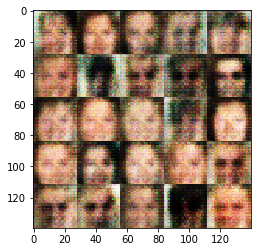

Epoch 1/1... Discriminator_Loss: 1.44526... Generator_Loss: 0.48105
Epoch 1/1... Discriminator_Loss: 1.44942... Generator_Loss: 0.53603
Epoch 1/1... Discriminator_Loss: 1.44261... Generator_Loss: 0.46415
Epoch 1/1... Discriminator_Loss: 1.24099... Generator_Loss: 0.78206
Epoch 1/1... Discriminator_Loss: 1.36485... Generator_Loss: 0.67183


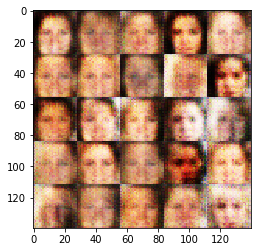

Epoch 1/1... Discriminator_Loss: 1.15514... Generator_Loss: 0.90626
Epoch 1/1... Discriminator_Loss: 1.62938... Generator_Loss: 0.38239
Epoch 1/1... Discriminator_Loss: 1.47730... Generator_Loss: 1.01774
Epoch 1/1... Discriminator_Loss: 1.45616... Generator_Loss: 0.45669
Epoch 1/1... Discriminator_Loss: 1.14163... Generator_Loss: 1.16327


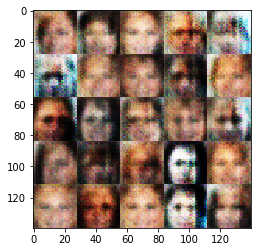

Epoch 1/1... Discriminator_Loss: 1.46746... Generator_Loss: 0.49003
Epoch 1/1... Discriminator_Loss: 1.64971... Generator_Loss: 0.52322
Epoch 1/1... Discriminator_Loss: 1.31949... Generator_Loss: 0.58735
Epoch 1/1... Discriminator_Loss: 1.43812... Generator_Loss: 0.81230
Epoch 1/1... Discriminator_Loss: 1.33520... Generator_Loss: 0.75024


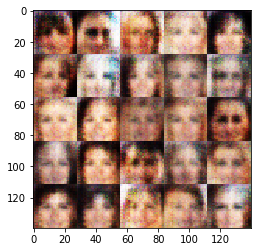

Epoch 1/1... Discriminator_Loss: 1.17753... Generator_Loss: 0.75212
Epoch 1/1... Discriminator_Loss: 1.33776... Generator_Loss: 0.62243
Epoch 1/1... Discriminator_Loss: 1.29136... Generator_Loss: 0.65323
Epoch 1/1... Discriminator_Loss: 1.39562... Generator_Loss: 0.99278
Epoch 1/1... Discriminator_Loss: 1.38087... Generator_Loss: 0.89874


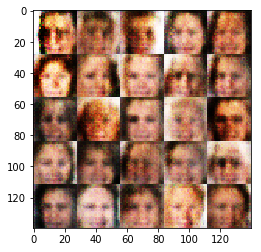

Epoch 1/1... Discriminator_Loss: 1.27980... Generator_Loss: 0.95177
Epoch 1/1... Discriminator_Loss: 1.34079... Generator_Loss: 1.38175
Epoch 1/1... Discriminator_Loss: 1.69029... Generator_Loss: 1.29104
Epoch 1/1... Discriminator_Loss: 1.49830... Generator_Loss: 0.90136
Epoch 1/1... Discriminator_Loss: 1.63512... Generator_Loss: 0.60814


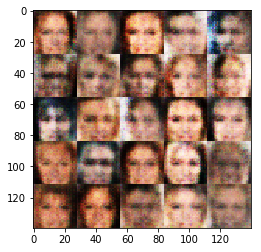

Epoch 1/1... Discriminator_Loss: 1.57043... Generator_Loss: 0.41245
Epoch 1/1... Discriminator_Loss: 1.25247... Generator_Loss: 0.92388
Epoch 1/1... Discriminator_Loss: 1.54062... Generator_Loss: 0.96017
Epoch 1/1... Discriminator_Loss: 1.47785... Generator_Loss: 0.91373
Epoch 1/1... Discriminator_Loss: 1.32344... Generator_Loss: 0.85699


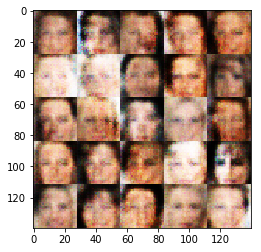

Epoch 1/1... Discriminator_Loss: 1.42286... Generator_Loss: 1.34726
Epoch 1/1... Discriminator_Loss: 1.32650... Generator_Loss: 1.21858
Epoch 1/1... Discriminator_Loss: 1.27631... Generator_Loss: 0.79684
Epoch 1/1... Discriminator_Loss: 1.51291... Generator_Loss: 0.46929
Epoch 1/1... Discriminator_Loss: 1.35546... Generator_Loss: 0.80420


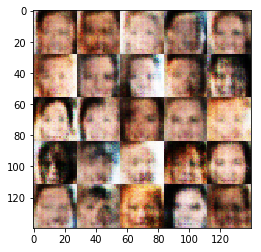

Epoch 1/1... Discriminator_Loss: 1.23907... Generator_Loss: 1.10520
Epoch 1/1... Discriminator_Loss: 1.51057... Generator_Loss: 0.48182
Epoch 1/1... Discriminator_Loss: 1.34227... Generator_Loss: 0.55358
Epoch 1/1... Discriminator_Loss: 1.50931... Generator_Loss: 0.51486
Epoch 1/1... Discriminator_Loss: 1.35665... Generator_Loss: 0.65328


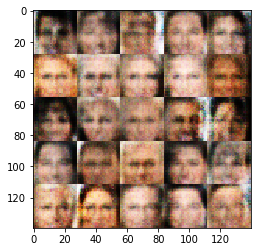

Epoch 1/1... Discriminator_Loss: 1.27541... Generator_Loss: 0.93909
Epoch 1/1... Discriminator_Loss: 1.36844... Generator_Loss: 0.87239
Epoch 1/1... Discriminator_Loss: 1.37893... Generator_Loss: 1.29368
Epoch 1/1... Discriminator_Loss: 1.25042... Generator_Loss: 0.98180
Epoch 1/1... Discriminator_Loss: 1.25635... Generator_Loss: 0.73190


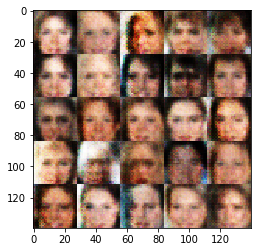

Epoch 1/1... Discriminator_Loss: 1.25680... Generator_Loss: 0.69390
Epoch 1/1... Discriminator_Loss: 1.38517... Generator_Loss: 0.61469
Epoch 1/1... Discriminator_Loss: 1.29800... Generator_Loss: 0.72129
Epoch 1/1... Discriminator_Loss: 1.36654... Generator_Loss: 1.20535
Epoch 1/1... Discriminator_Loss: 1.37217... Generator_Loss: 0.70748


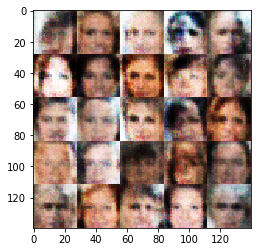

Epoch 1/1... Discriminator_Loss: 1.24613... Generator_Loss: 0.85556
Epoch 1/1... Discriminator_Loss: 1.34205... Generator_Loss: 0.62883
Epoch 1/1... Discriminator_Loss: 1.46111... Generator_Loss: 1.39627
Epoch 1/1... Discriminator_Loss: 1.22792... Generator_Loss: 0.89416
Epoch 1/1... Discriminator_Loss: 1.37153... Generator_Loss: 0.58733


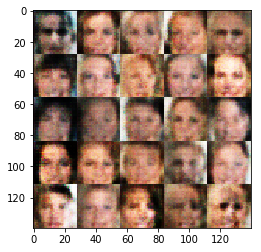

Epoch 1/1... Discriminator_Loss: 1.41926... Generator_Loss: 0.55041
Epoch 1/1... Discriminator_Loss: 1.27831... Generator_Loss: 0.62681
Epoch 1/1... Discriminator_Loss: 1.25904... Generator_Loss: 0.89023
Epoch 1/1... Discriminator_Loss: 1.48872... Generator_Loss: 0.57410
Epoch 1/1... Discriminator_Loss: 1.41361... Generator_Loss: 0.51064


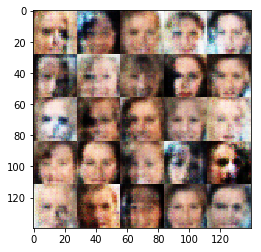

Epoch 1/1... Discriminator_Loss: 1.39836... Generator_Loss: 0.57781
Epoch 1/1... Discriminator_Loss: 1.45981... Generator_Loss: 1.24126
Epoch 1/1... Discriminator_Loss: 1.27687... Generator_Loss: 0.70266
Epoch 1/1... Discriminator_Loss: 1.33082... Generator_Loss: 0.97216
Epoch 1/1... Discriminator_Loss: 1.52716... Generator_Loss: 1.51652


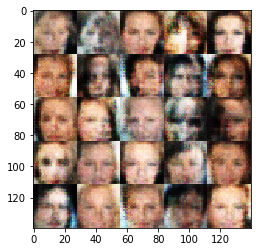

Epoch 1/1... Discriminator_Loss: 1.15087... Generator_Loss: 0.81631
Epoch 1/1... Discriminator_Loss: 1.37579... Generator_Loss: 0.89689
Epoch 1/1... Discriminator_Loss: 1.30595... Generator_Loss: 1.01065
Epoch 1/1... Discriminator_Loss: 1.44171... Generator_Loss: 1.56852
Epoch 1/1... Discriminator_Loss: 1.29829... Generator_Loss: 0.62819


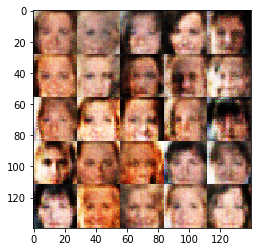

Epoch 1/1... Discriminator_Loss: 1.35187... Generator_Loss: 0.70611
Epoch 1/1... Discriminator_Loss: 1.40017... Generator_Loss: 0.98425
Epoch 1/1... Discriminator_Loss: 1.22856... Generator_Loss: 0.79097
Epoch 1/1... Discriminator_Loss: 1.40887... Generator_Loss: 0.55062
Epoch 1/1... Discriminator_Loss: 1.59188... Generator_Loss: 0.35932


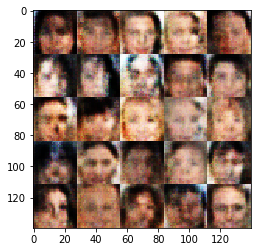

Epoch 1/1... Discriminator_Loss: 1.32094... Generator_Loss: 1.01449
Epoch 1/1... Discriminator_Loss: 1.30282... Generator_Loss: 0.73329
Epoch 1/1... Discriminator_Loss: 1.64423... Generator_Loss: 1.32136
Epoch 1/1... Discriminator_Loss: 1.31980... Generator_Loss: 1.19087
Epoch 1/1... Discriminator_Loss: 1.19346... Generator_Loss: 0.69375


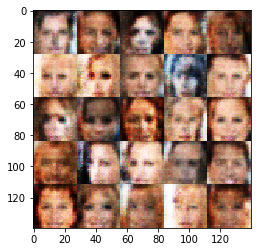

Epoch 1/1... Discriminator_Loss: 1.32134... Generator_Loss: 0.88473
Epoch 1/1... Discriminator_Loss: 1.22581... Generator_Loss: 1.28766
Epoch 1/1... Discriminator_Loss: 1.30567... Generator_Loss: 0.86804
Epoch 1/1... Discriminator_Loss: 1.37446... Generator_Loss: 0.59852
Epoch 1/1... Discriminator_Loss: 1.27909... Generator_Loss: 0.79596


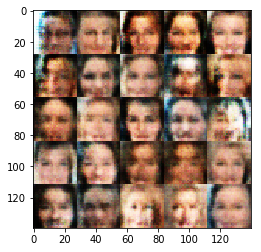

Epoch 1/1... Discriminator_Loss: 1.35201... Generator_Loss: 0.99445
Epoch 1/1... Discriminator_Loss: 1.21646... Generator_Loss: 1.13608
Epoch 1/1... Discriminator_Loss: 1.25370... Generator_Loss: 0.79976
Epoch 1/1... Discriminator_Loss: 1.42747... Generator_Loss: 0.48459
Epoch 1/1... Discriminator_Loss: 1.27140... Generator_Loss: 0.89507


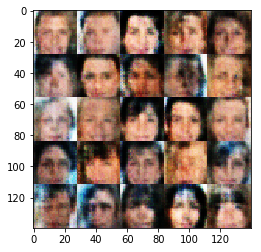

Epoch 1/1... Discriminator_Loss: 1.42053... Generator_Loss: 1.06183
Epoch 1/1... Discriminator_Loss: 1.30119... Generator_Loss: 0.81675
Epoch 1/1... Discriminator_Loss: 1.28931... Generator_Loss: 0.61026
Epoch 1/1... Discriminator_Loss: 1.27265... Generator_Loss: 0.73542
Epoch 1/1... Discriminator_Loss: 1.35672... Generator_Loss: 0.54769


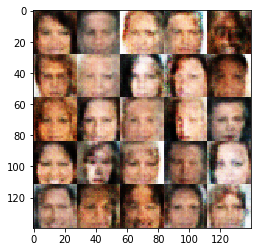

Epoch 1/1... Discriminator_Loss: 1.43647... Generator_Loss: 0.52764
Epoch 1/1... Discriminator_Loss: 1.27154... Generator_Loss: 0.80728
Epoch 1/1... Discriminator_Loss: 1.27622... Generator_Loss: 0.59143
Epoch 1/1... Discriminator_Loss: 1.50974... Generator_Loss: 0.44441
Epoch 1/1... Discriminator_Loss: 1.21372... Generator_Loss: 0.80392


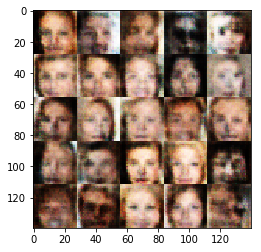

Epoch 1/1... Discriminator_Loss: 1.33245... Generator_Loss: 0.88802
Epoch 1/1... Discriminator_Loss: 1.18143... Generator_Loss: 1.00656
Epoch 1/1... Discriminator_Loss: 1.39963... Generator_Loss: 1.12144
Epoch 1/1... Discriminator_Loss: 1.37720... Generator_Loss: 0.71233
Epoch 1/1... Discriminator_Loss: 1.41897... Generator_Loss: 0.75727


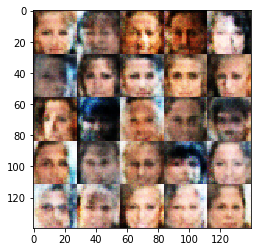

Epoch 1/1... Discriminator_Loss: 1.25604... Generator_Loss: 0.64444
Epoch 1/1... Discriminator_Loss: 1.32861... Generator_Loss: 0.87626
Epoch 1/1... Discriminator_Loss: 1.21547... Generator_Loss: 0.73664
Epoch 1/1... Discriminator_Loss: 1.35262... Generator_Loss: 0.59301
Epoch 1/1... Discriminator_Loss: 1.28240... Generator_Loss: 0.65784


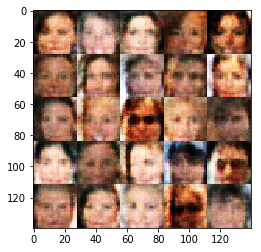

Epoch 1/1... Discriminator_Loss: 1.34816... Generator_Loss: 0.59294
Epoch 1/1... Discriminator_Loss: 1.40353... Generator_Loss: 1.26718
Epoch 1/1... Discriminator_Loss: 1.46424... Generator_Loss: 0.52685
Epoch 1/1... Discriminator_Loss: 1.32510... Generator_Loss: 1.17382
Epoch 1/1... Discriminator_Loss: 1.16293... Generator_Loss: 0.82646


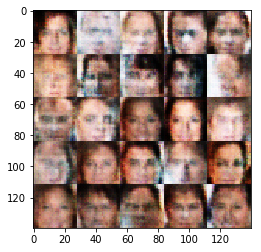

Epoch 1/1... Discriminator_Loss: 1.28287... Generator_Loss: 0.80390
Epoch 1/1... Discriminator_Loss: 1.33715... Generator_Loss: 0.90089
Epoch 1/1... Discriminator_Loss: 1.28368... Generator_Loss: 0.77365
Epoch 1/1... Discriminator_Loss: 1.74772... Generator_Loss: 0.32481
Epoch 1/1... Discriminator_Loss: 1.13583... Generator_Loss: 0.82410


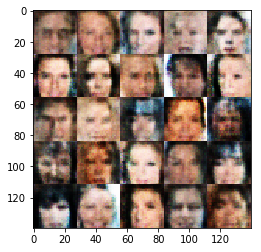

Epoch 1/1... Discriminator_Loss: 1.21116... Generator_Loss: 1.15576
Epoch 1/1... Discriminator_Loss: 1.32437... Generator_Loss: 0.95090
Epoch 1/1... Discriminator_Loss: 1.31671... Generator_Loss: 0.54307
Epoch 1/1... Discriminator_Loss: 1.44389... Generator_Loss: 1.00313
Epoch 1/1... Discriminator_Loss: 1.23619... Generator_Loss: 1.01937


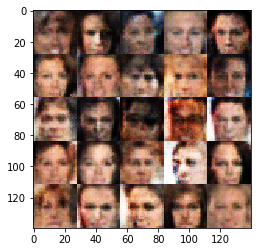

Epoch 1/1... Discriminator_Loss: 1.27873... Generator_Loss: 0.64645
Epoch 1/1... Discriminator_Loss: 1.43133... Generator_Loss: 0.62722
Epoch 1/1... Discriminator_Loss: 1.24920... Generator_Loss: 0.78233
Epoch 1/1... Discriminator_Loss: 1.24824... Generator_Loss: 0.67815
Epoch 1/1... Discriminator_Loss: 1.24203... Generator_Loss: 0.73927


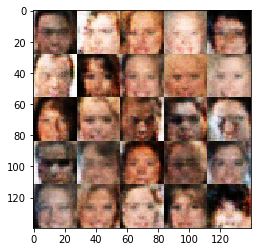

Epoch 1/1... Discriminator_Loss: 1.40678... Generator_Loss: 0.50530
Epoch 1/1... Discriminator_Loss: 1.23661... Generator_Loss: 1.03187
Epoch 1/1... Discriminator_Loss: 1.19354... Generator_Loss: 0.75070
Epoch 1/1... Discriminator_Loss: 1.53467... Generator_Loss: 0.42626
Epoch 1/1... Discriminator_Loss: 1.41008... Generator_Loss: 0.96535


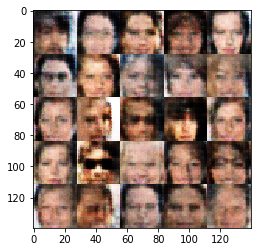

Epoch 1/1... Discriminator_Loss: 1.20446... Generator_Loss: 1.10456
Epoch 1/1... Discriminator_Loss: 1.41680... Generator_Loss: 0.70726
Epoch 1/1... Discriminator_Loss: 1.36408... Generator_Loss: 0.99413
Epoch 1/1... Discriminator_Loss: 1.39315... Generator_Loss: 0.68148
Epoch 1/1... Discriminator_Loss: 1.27245... Generator_Loss: 1.05384


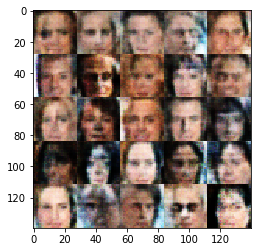

Epoch 1/1... Discriminator_Loss: 1.33938... Generator_Loss: 0.59811
Epoch 1/1... Discriminator_Loss: 1.39543... Generator_Loss: 1.37412
Epoch 1/1... Discriminator_Loss: 1.32248... Generator_Loss: 0.80764
Epoch 1/1... Discriminator_Loss: 1.40558... Generator_Loss: 0.73931
Epoch 1/1... Discriminator_Loss: 1.27587... Generator_Loss: 0.69275


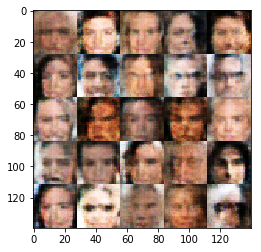

Epoch 1/1... Discriminator_Loss: 1.46245... Generator_Loss: 0.44826
Epoch 1/1... Discriminator_Loss: 1.26136... Generator_Loss: 0.66166
Epoch 1/1... Discriminator_Loss: 1.32311... Generator_Loss: 1.27347
Epoch 1/1... Discriminator_Loss: 1.38706... Generator_Loss: 0.52636
Epoch 1/1... Discriminator_Loss: 1.41148... Generator_Loss: 0.79342


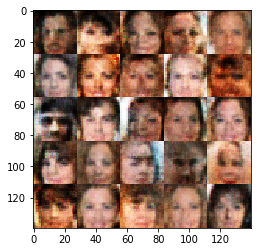

Epoch 1/1... Discriminator_Loss: 1.09573... Generator_Loss: 0.87386
Epoch 1/1... Discriminator_Loss: 1.43926... Generator_Loss: 0.50047
Epoch 1/1... Discriminator_Loss: 1.41963... Generator_Loss: 0.54233
Epoch 1/1... Discriminator_Loss: 1.31072... Generator_Loss: 0.71639
Epoch 1/1... Discriminator_Loss: 1.52505... Generator_Loss: 0.50070


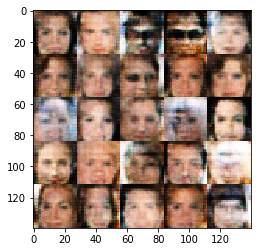

Epoch 1/1... Discriminator_Loss: 1.44730... Generator_Loss: 1.27378
Epoch 1/1... Discriminator_Loss: 1.38274... Generator_Loss: 0.54530
Epoch 1/1... Discriminator_Loss: 1.40321... Generator_Loss: 0.48349
Epoch 1/1... Discriminator_Loss: 1.33196... Generator_Loss: 1.29515
Epoch 1/1... Discriminator_Loss: 1.29225... Generator_Loss: 0.82729


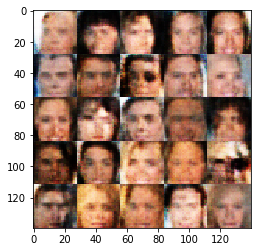

Epoch 1/1... Discriminator_Loss: 1.55720... Generator_Loss: 0.38503
Epoch 1/1... Discriminator_Loss: 1.40509... Generator_Loss: 1.10253
Epoch 1/1... Discriminator_Loss: 1.16956... Generator_Loss: 0.82397
Epoch 1/1... Discriminator_Loss: 1.34083... Generator_Loss: 0.89559
Epoch 1/1... Discriminator_Loss: 1.32866... Generator_Loss: 0.65509


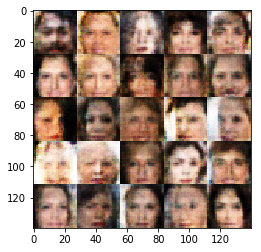

Epoch 1/1... Discriminator_Loss: 1.37204... Generator_Loss: 1.01688
Epoch 1/1... Discriminator_Loss: 1.53958... Generator_Loss: 1.58213
Epoch 1/1... Discriminator_Loss: 1.67696... Generator_Loss: 0.34052
Epoch 1/1... Discriminator_Loss: 1.30869... Generator_Loss: 0.91012
Epoch 1/1... Discriminator_Loss: 1.23259... Generator_Loss: 0.86609


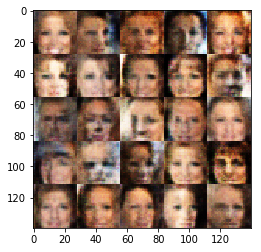

Epoch 1/1... Discriminator_Loss: 1.56954... Generator_Loss: 0.40281
Epoch 1/1... Discriminator_Loss: 1.14619... Generator_Loss: 0.92617
Epoch 1/1... Discriminator_Loss: 1.30379... Generator_Loss: 0.56522
Epoch 1/1... Discriminator_Loss: 1.36691... Generator_Loss: 0.71735
Epoch 1/1... Discriminator_Loss: 1.61894... Generator_Loss: 0.36352


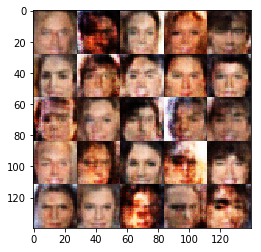

Epoch 1/1... Discriminator_Loss: 1.40910... Generator_Loss: 0.44920
Epoch 1/1... Discriminator_Loss: 1.30155... Generator_Loss: 1.01584
Epoch 1/1... Discriminator_Loss: 1.07745... Generator_Loss: 1.03685
Epoch 1/1... Discriminator_Loss: 1.18413... Generator_Loss: 1.29799
Epoch 1/1... Discriminator_Loss: 1.69879... Generator_Loss: 0.31761


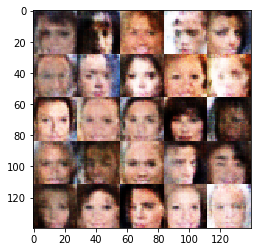

Epoch 1/1... Discriminator_Loss: 1.25399... Generator_Loss: 0.58818
Epoch 1/1... Discriminator_Loss: 1.60638... Generator_Loss: 0.37132
Epoch 1/1... Discriminator_Loss: 1.25036... Generator_Loss: 0.70931
Epoch 1/1... Discriminator_Loss: 1.48582... Generator_Loss: 0.45655
Epoch 1/1... Discriminator_Loss: 1.38214... Generator_Loss: 0.51599


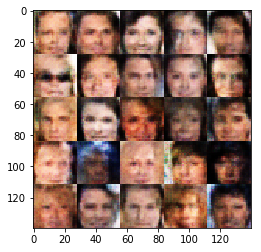

Epoch 1/1... Discriminator_Loss: 1.44365... Generator_Loss: 0.45269
Epoch 1/1... Discriminator_Loss: 1.30334... Generator_Loss: 1.16104
Epoch 1/1... Discriminator_Loss: 1.24416... Generator_Loss: 0.70422
Epoch 1/1... Discriminator_Loss: 1.23551... Generator_Loss: 1.20397
Epoch 1/1... Discriminator_Loss: 1.73189... Generator_Loss: 0.30841


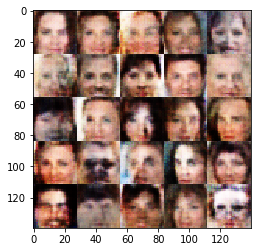

Epoch 1/1... Discriminator_Loss: 1.44697... Generator_Loss: 0.49237
Epoch 1/1... Discriminator_Loss: 1.36531... Generator_Loss: 1.63561
Epoch 1/1... Discriminator_Loss: 1.42642... Generator_Loss: 0.49051
Epoch 1/1... Discriminator_Loss: 1.35998... Generator_Loss: 0.63188
Epoch 1/1... Discriminator_Loss: 1.15352... Generator_Loss: 0.85654


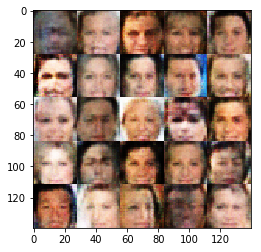

Epoch 1/1... Discriminator_Loss: 1.30159... Generator_Loss: 0.63018
Epoch 1/1... Discriminator_Loss: 1.64097... Generator_Loss: 0.34619
Epoch 1/1... Discriminator_Loss: 1.39532... Generator_Loss: 0.55541
Epoch 1/1... Discriminator_Loss: 1.14676... Generator_Loss: 0.86591
Epoch 1/1... Discriminator_Loss: 1.28914... Generator_Loss: 1.54242


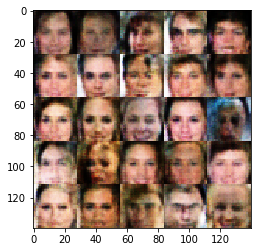

Epoch 1/1... Discriminator_Loss: 1.18066... Generator_Loss: 0.89207
Epoch 1/1... Discriminator_Loss: 1.54812... Generator_Loss: 0.41019
Epoch 1/1... Discriminator_Loss: 1.59401... Generator_Loss: 0.40192
Epoch 1/1... Discriminator_Loss: 1.24497... Generator_Loss: 0.69774
Epoch 1/1... Discriminator_Loss: 1.49334... Generator_Loss: 0.60465


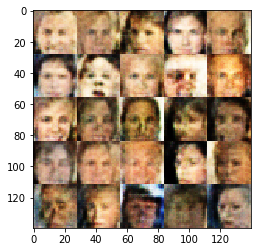

Epoch 1/1... Discriminator_Loss: 1.87768... Generator_Loss: 1.95589
Epoch 1/1... Discriminator_Loss: 1.22711... Generator_Loss: 1.06523
Epoch 1/1... Discriminator_Loss: 1.87515... Generator_Loss: 0.26424
Epoch 1/1... Discriminator_Loss: 1.30981... Generator_Loss: 0.67502
Epoch 1/1... Discriminator_Loss: 1.26612... Generator_Loss: 0.80195


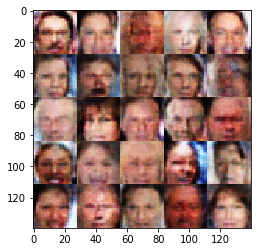

Epoch 1/1... Discriminator_Loss: 1.35034... Generator_Loss: 0.56541
Epoch 1/1... Discriminator_Loss: 1.37602... Generator_Loss: 1.75307
Epoch 1/1... Discriminator_Loss: 1.35484... Generator_Loss: 0.55325
Epoch 1/1... Discriminator_Loss: 1.27508... Generator_Loss: 0.89367
Epoch 1/1... Discriminator_Loss: 1.45827... Generator_Loss: 0.48906


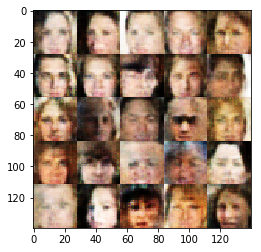

Epoch 1/1... Discriminator_Loss: 1.27749... Generator_Loss: 0.64894
Epoch 1/1... Discriminator_Loss: 1.33880... Generator_Loss: 1.27885
Epoch 1/1... Discriminator_Loss: 1.43498... Generator_Loss: 1.56373
Epoch 1/1... Discriminator_Loss: 1.21658... Generator_Loss: 1.09886
Epoch 1/1... Discriminator_Loss: 1.52996... Generator_Loss: 0.43280


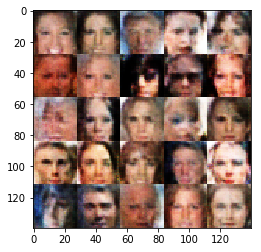

Epoch 1/1... Discriminator_Loss: 1.48083... Generator_Loss: 0.45827
Epoch 1/1... Discriminator_Loss: 1.21213... Generator_Loss: 0.73818
Epoch 1/1... Discriminator_Loss: 1.46687... Generator_Loss: 0.65996
Epoch 1/1... Discriminator_Loss: 1.63424... Generator_Loss: 0.36767
Epoch 1/1... Discriminator_Loss: 1.50923... Generator_Loss: 0.61081


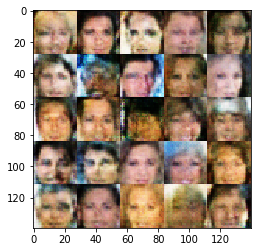

Epoch 1/1... Discriminator_Loss: 1.33345... Generator_Loss: 0.91375
Epoch 1/1... Discriminator_Loss: 1.46880... Generator_Loss: 0.52961
Epoch 1/1... Discriminator_Loss: 1.22295... Generator_Loss: 0.69520
Epoch 1/1... Discriminator_Loss: 1.51094... Generator_Loss: 0.41464
Epoch 1/1... Discriminator_Loss: 1.72568... Generator_Loss: 0.31064


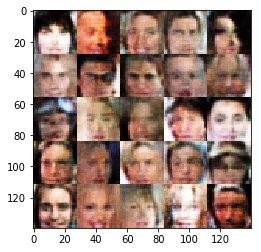

Epoch 1/1... Discriminator_Loss: 1.67331... Generator_Loss: 0.36268
Epoch 1/1... Discriminator_Loss: 1.17268... Generator_Loss: 1.31353
Epoch 1/1... Discriminator_Loss: 1.33465... Generator_Loss: 1.23698
Epoch 1/1... Discriminator_Loss: 1.39926... Generator_Loss: 0.53843
Epoch 1/1... Discriminator_Loss: 1.29799... Generator_Loss: 0.59758


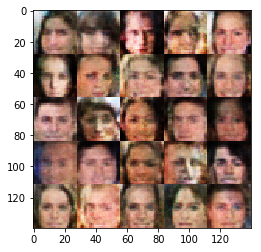

Epoch 1/1... Discriminator_Loss: 1.37594... Generator_Loss: 0.52939
Epoch 1/1... Discriminator_Loss: 1.44009... Generator_Loss: 0.51806
Epoch 1/1... Discriminator_Loss: 1.35041... Generator_Loss: 1.22177
Epoch 1/1... Discriminator_Loss: 1.24500... Generator_Loss: 0.98540
Epoch 1/1... Discriminator_Loss: 1.31778... Generator_Loss: 0.57594


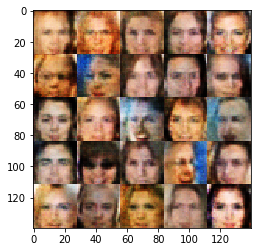

Epoch 1/1... Discriminator_Loss: 1.23481... Generator_Loss: 0.67869
Epoch 1/1... Discriminator_Loss: 1.56055... Generator_Loss: 0.38337
Epoch 1/1... Discriminator_Loss: 1.13289... Generator_Loss: 0.74512
Epoch 1/1... Discriminator_Loss: 1.07718... Generator_Loss: 0.99639
Epoch 1/1... Discriminator_Loss: 0.99924... Generator_Loss: 1.24238


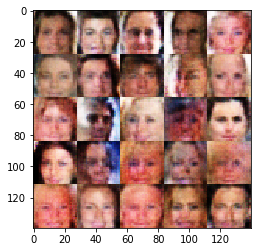

Epoch 1/1... Discriminator_Loss: 1.31893... Generator_Loss: 1.05326
Epoch 1/1... Discriminator_Loss: 1.06632... Generator_Loss: 1.02084
Epoch 1/1... Discriminator_Loss: 1.32868... Generator_Loss: 0.65304
Epoch 1/1... Discriminator_Loss: 1.20529... Generator_Loss: 1.21639
Epoch 1/1... Discriminator_Loss: 1.55179... Generator_Loss: 0.41216


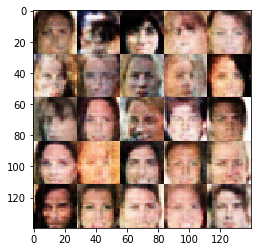

Epoch 1/1... Discriminator_Loss: 1.37964... Generator_Loss: 1.11383
Epoch 1/1... Discriminator_Loss: 1.03717... Generator_Loss: 1.15549
Epoch 1/1... Discriminator_Loss: 1.36180... Generator_Loss: 1.07938
Epoch 1/1... Discriminator_Loss: 1.36568... Generator_Loss: 1.37587
Epoch 1/1... Discriminator_Loss: 1.22872... Generator_Loss: 1.13166


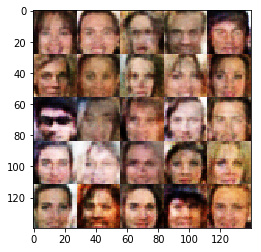

Epoch 1/1... Discriminator_Loss: 1.35361... Generator_Loss: 0.53727
Epoch 1/1... Discriminator_Loss: 1.50463... Generator_Loss: 0.44889
Epoch 1/1... Discriminator_Loss: 1.21855... Generator_Loss: 0.71796
Epoch 1/1... Discriminator_Loss: 1.30828... Generator_Loss: 0.66405
Epoch 1/1... Discriminator_Loss: 1.29270... Generator_Loss: 0.99753


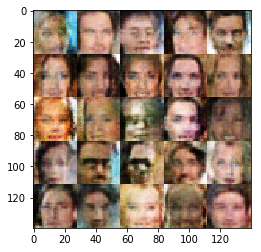

Epoch 1/1... Discriminator_Loss: 1.16218... Generator_Loss: 1.04673
Epoch 1/1... Discriminator_Loss: 1.47171... Generator_Loss: 0.55318
Epoch 1/1... Discriminator_Loss: 1.33539... Generator_Loss: 0.86157
Epoch 1/1... Discriminator_Loss: 1.19983... Generator_Loss: 0.71574
Epoch 1/1... Discriminator_Loss: 1.34904... Generator_Loss: 0.59576


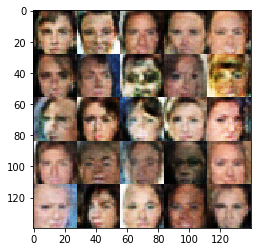

Epoch 1/1... Discriminator_Loss: 1.51271... Generator_Loss: 0.46835
Epoch 1/1... Discriminator_Loss: 1.20828... Generator_Loss: 0.90315
Epoch 1/1... Discriminator_Loss: 1.26800... Generator_Loss: 1.05511
Epoch 1/1... Discriminator_Loss: 1.17818... Generator_Loss: 1.01504
Epoch 1/1... Discriminator_Loss: 1.16402... Generator_Loss: 0.83608


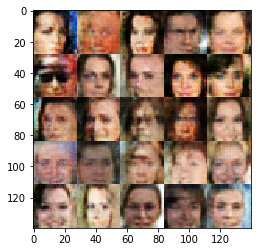

Epoch 1/1... Discriminator_Loss: 0.95719... Generator_Loss: 1.19032
Epoch 1/1... Discriminator_Loss: 1.37417... Generator_Loss: 0.61603
Epoch 1/1... Discriminator_Loss: 1.36172... Generator_Loss: 0.73320
Epoch 1/1... Discriminator_Loss: 1.14100... Generator_Loss: 1.14461
Epoch 1/1... Discriminator_Loss: 1.24437... Generator_Loss: 0.72997


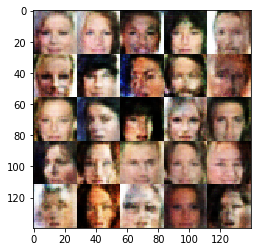

Epoch 1/1... Discriminator_Loss: 1.17799... Generator_Loss: 1.13177
Epoch 1/1... Discriminator_Loss: 1.26818... Generator_Loss: 0.63159
Epoch 1/1... Discriminator_Loss: 1.56923... Generator_Loss: 0.40115
Epoch 1/1... Discriminator_Loss: 1.25244... Generator_Loss: 1.02576
Epoch 1/1... Discriminator_Loss: 1.32196... Generator_Loss: 0.73193


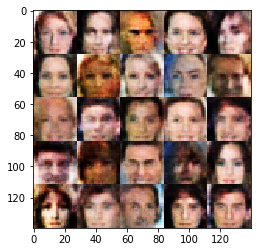

Epoch 1/1... Discriminator_Loss: 1.26523... Generator_Loss: 0.77276


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.